Sentiment Analysis uses natural language processing to attempt to detect sentiment in some text, for example:
This is bad! It is going to fail!  - Negative Sentiment
Great Job! It is a winner - Positive Sentiment

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import trange, tqdm
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import zipfile
import random
import yfinance as yf
import numpy as np
import copy

In [7]:
pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-5odjhlzd
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-5odjhlzd
  Resolved https://github.com/huggingface/transformers.git to commit e5fd865ebae062b7cf03a81b8c6affeb39f30bec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10329101 sha256=e62f67a5feaaba4d53736bc3ab2b4849b7addc4d60b4eba7ddb629e36fd91736
  Stored in directory: /tmp/pip-ephem-wheel-cache-4blxnitc/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [8]:
#I will use a model that was specifically fine-tuned on online social media comments around financial markets
from transformers import BertForSequenceClassification, AutoTokenizer, pipeline
model = BertForSequenceClassification.from_pretrained(
    "StephanAkkerman/FinTwitBERT-sentiment",
    num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2},
)
model.eval()

#I will use the tokenizer that was used to fine-tune the model
tokenizer = AutoTokenizer.from_pretrained("StephanAkkerman/FinTwitBERT-sentiment")

#Constructing a Hugging Face pipeline
sentiment_classifier = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=1,
    top_k=None, padding=True, truncation=True, max_length=512
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/713k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cpu


In [9]:
import zipfile
import os
from torch.utils.data import Dataset

class MyTextDataset(Dataset):
    def __init__(self, root_data_dir, stock_code, tokenizer, max_length=512):
        self.root_data_dir = root_data_dir
        self.stock_code = stock_code

        # To ensure the data is unzipped
        self.check_and_unzip()

        self.data_dir = os.path.join(self.root_data_dir, self.stock_code)

        # Get the list of files in the unzipped directory
        self.file_list = os.listdir(self.data_dir)
        self.num_samples = len(self.file_list)

    def check_and_unzip(self):  # Fixed method name
        zip_file_name = self.stock_code + ".zip"
        zip_path = os.path.join(self.root_data_dir, zip_file_name)
        extracted_dir = os.path.join(self.root_data_dir, self.stock_code)

        # Check if the extracted directory already exists
        if not os.path.exists(extracted_dir):
            # Check if the .zip file exists in the specified directory
            if os.path.exists(zip_path):
                # Unzip the file
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:  # Create a ZipFile object
                    zip_ref.extractall(self.root_data_dir)  # Extract all the contents of zip file in the current directory
                print(f"Extracted {zip_file_name} to {self.root_data_dir}")  # Print a success message
            else:
                print(f"{zip_file_name} not found in {self.root_data_dir}")
        else:
            print(f"Directory {extracted_dir} already exists, skipping extraction.")

    # Define the __len__ method
    def __len__(self):
        return self.num_samples

    # Define the __getitem__ method
    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_list[idx])
        with open(file_path, 'r', encoding='utf-8') as file:
            raw_data = file.read()

        # Extract the text and time data
        text_data = raw_data.split(" : ")[-1]
        time_data = raw_data.split(" : ")[0]

        return text_data, time_data


In [11]:
import zipfile
import os

# Define the path to the zip file and the directory to unzip to
zip_file_path = "/content/nab.zip"  # Path to my zip file
extract_dir = "/content/nab"  # Directory to unzip the contents into

# To unzip the file manually
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File unzipped to {extract_dir}")

# Now use the extracted folder for your dataset
root_data_dir = extract_dir  # Correct directory
stock_code = "nab"  # Example stock code

# Initialise the dataset with the correct path
dataset = MyTextDataset(root_data_dir, stock_code, tokenizer)

# Initialise the DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Iterating through the DataLoader
for batch in loader:
    print(batch)
    break  # Just print the first batch as an example



File unzipped to /content/nab
Directory /content/nab/nab already exists, skipping extraction.
[('Rumour has it..It has to do with the sale of the Life Insurance Business...\n\nOct 27, 20159:06 AM\n[TOKYO] Japan\'s Nippon Life Insurance Company has agreed to buy 80 per cent of National Australia Bank\'s life insurance unit for about 200 billion yen (US$1.65 billion), a source with direct knowledge of the matter told Reuters.\nEarlier in the day, NAB, Australia\'s No1 lender by assets, placed its shares on a trading halt ahead of an announcement of a "material transaction".\nAn announcement on the sale of NAB\'s insurance unit is expected on Wednesday when the lender announces full-year earnings, the source, who could not be identified, added.\nREUTERS', 'Release Date: 19/12/23 18:08\nSummary: Update - Notification of buy-back - NAB\nPrice Sensitive: No\nDownload Document\xa0\xa024.78KB\n\n\n\n\n\n\nDownload', 'Release Date: 17/09/24 08:24\nSummary: Notification of cessation of securitie

In [12]:
# Example: Accessing a single item from the dataset
text_data, time_data = dataset.__getitem__(100)

In [13]:
time_data

'2020-03-20T18:22:00+11:00'

In [14]:
text_data

'Well this is the summary in the media release.................\n\n\n\nI think some are confused on some of this.\nAs I said earlier, loan repayments are not income for the banks!!\nThe Banks account for the interest and fees charged to the loans as income and they certainly have not said they are going to stop charging interest and fees. It is purely for cash flow assistance to borrowers at this stage.'

In [15]:
# Example: Using the sentiment classifier pipeline
rand_indx = random.randint(0, len(dataset))
text_data, time_data = dataset.__getitem__(rand_indx)
with torch.cuda.amp.autocast():
        outputs = sentiment_classifier([text_data])

# Print the text data and the sentiment prediction
print(text_data)
print("\n")

print("This comment is rated %s with confidence %.3f" % (outputs[0][0]["label"], outputs[0][0]["score"]))

<ipython-input-15-2e73c21e3b87>:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(Adds more detail) 	LONDON, Sept 20 (Reuters) - Royal Bank of Scotland  RBS.L  has appointed Alison Rose as its new chief executive, becoming the first major British lender to appoint a woman to its top job. 	Rose, who was widely tipped to get the role, will succeed outgoing CEO Ross McEwan on November 1. He is due to join National Australia Bank  (NAB)  as their next chief executive.  	Rose has worked at the bank for 27 years and takes on the role at a pivotal time for the lender, as British banks prepare for the economic fallout if Britain leaves the European Union without a deal next month. 	She will also be tasked with further patching up RBS's damaged reputation and trying to return the bank to private hands, more than a decade after its 45 billion pound state rescue in the financial crisis. 	"Following a rigorous internal and external process, I am confident that we have appointed the best person for the job," RBS Chairman Howard Davies said in a statement. 	 Rose will receive a 

In [16]:
outputs

[[{'label': 'neutral', 'score': 0.7042940258979797},
  {'label': 'positive', 'score': 0.19075316190719604},
  {'label': 'negative', 'score': 0.10495278984308243}]]

Predict the Sentiment of Comments

In [21]:
import torch
from transformers import pipeline
from tqdm import tqdm  # For progress bar

# Check if CUDA is available, if not, use CPU
device = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU

# Constructing a Hugging Face pipeline with the device specified
sentiment_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,  # Set device to 0 (GPU) or -1 (CPU)
    top_k=None,
    padding=True,
    truncation=True,
    max_length=512
)

# Example: Using the sentiment classifier pipeline
log_positive_score = []
log_neutral_score = []
log_negative_score = []
log_datetime = []

# Define the batch size
batch_size = 16  # Adjust this value as needed

# Iterate through the DataLoader in batches
for i, (batch_input_data, batch_time_data) in enumerate(tqdm(loader)):
    if i * batch_size >= len(loader):
        break

    with torch.no_grad():  # No need to track gradients during inference
        # Run the model on the selected device (GPU or CPU)
        outputs = sentiment_classifier(list(batch_input_data))  # Pass a batch of input data to the model

    # Extract the sentiment scores and time data
    for output, td in zip(outputs, batch_time_data):
        for label in output:
            if label["label"] == 'positive':
                log_positive_score.append(label["score"])
            elif label["label"] == 'neutral':
                log_neutral_score.append(label["score"])
            elif label["label"] == 'negative':
                log_negative_score.append(label["score"])

        # Convert the time data to a datetime object
        log_datetime.append(td)



Device set to use cpu
  6%|▋         | 34/531 [06:49<1:39:41, 12.03s/it]


Orgainising the Data

In [22]:
import pandas as pd
# Create a panda dataframe
df = pd.DataFrame({
    'Datetime': log_datetime,
    'positive': log_positive_score,
    'neutral': log_neutral_score,
    'negative': log_negative_score,

})
# Set index to the date time
df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)

# Sort all rows by the datetimeindex
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

To calculate the semantic score

In [23]:
# Calculate a 'score' using the positive and negative predictions
df['score'] = (df['positive'] - df['negative'])/(df['positive'] + df['negative'])

# Calculate median sentiment for everyday
df_daily = df.resample('D').median()
df_daily.fillna(0, inplace=True)

# Count the number of entries per day
df_daily_count = df.resample('D').size()

# If you want to add this count to your existing df_daily DataFrame:
df_daily['entry_count'] = df_daily_count
df_daily['entry_count_ma'] = df_daily['entry_count'].rolling(window=28, center=False).mean()

# Calculate a 28 day moving average of the score
df_daily['score_ma'] = df_daily['score'].rolling(window=28, center=False).mean()

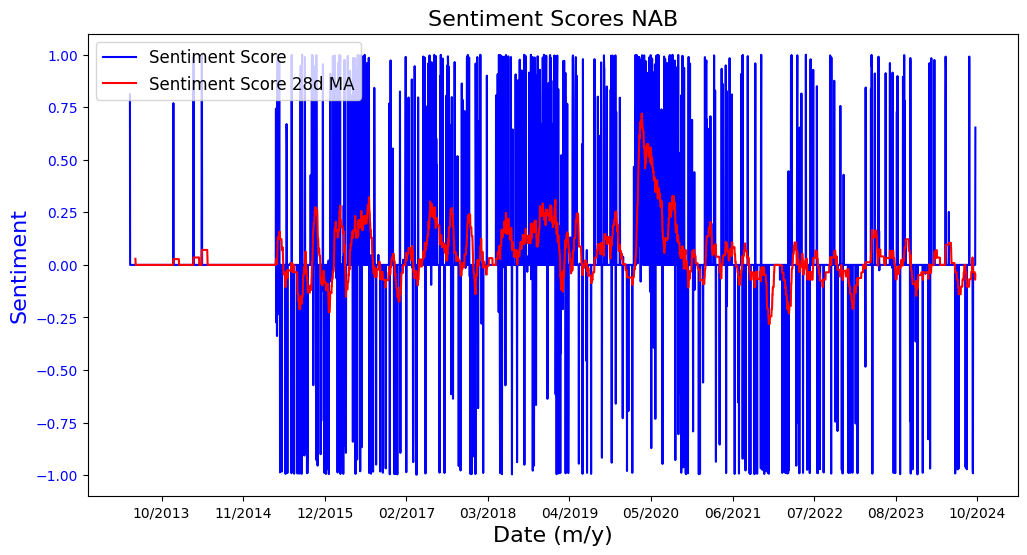

In [26]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_daily.index,
         df_daily['score'], color='blue', label='Sentiment Score')

ax1.plot(df_daily.index,
         df_daily['score_ma'], color='red', label='Sentiment Score 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment Scores ' + stock_code.upper(), fontsize=16)

Get the Stock Price to Compare

In [28]:
import yfinance as yf
import pandas as pd

# Set the stock code (adjust as necessary)
stock_code = 'NAB'

# Download the stock price data (using '10y' instead of '9y' for the period)
msft = yf.Ticker(stock_code + ".AX")
stock_data = msft.history(period="10y", interval="1d")

# Check if 'Dividends' column exists and drop it if present
if 'Dividends' in stock_data.columns:
    stock_data.drop('Dividends', axis=1, inplace=True)

# Check if 'Stock Splits' column exists and drop it if present
if 'Stock Splits' in stock_data.columns:
    stock_data.drop('Stock Splits', axis=1, inplace=True)

# Get a price for every day (including weekends, etc.)
stock_data = stock_data.resample('D').mean()

# Fill forward price data (carry the price data forward for weekends, etc.)
stock_data.fillna(method='ffill', inplace=True)

# Get a 28-day and 120-day moving average of the close price
stock_data['close_ma'] = stock_data['Close'].rolling(window=28, center=False).mean()
stock_data['close_120_ma'] = stock_data['Close'].rolling(window=120, center=False).mean()

# Calculate the short-term price movements by subtracting the 120-day MA from the close price
stock_data['close_diff'] = stock_data['Close'] - stock_data['close_120_ma']

<ipython-input-28-21b35f08fdff>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [29]:
# Cut the sentiment data to match the same time period as the stock price data
specific_date = stock_data.index[0]

# Filter the DataFrame to get data after the specific date
df_after_specific_date = df_daily.loc[specific_date:]

Plot the results!

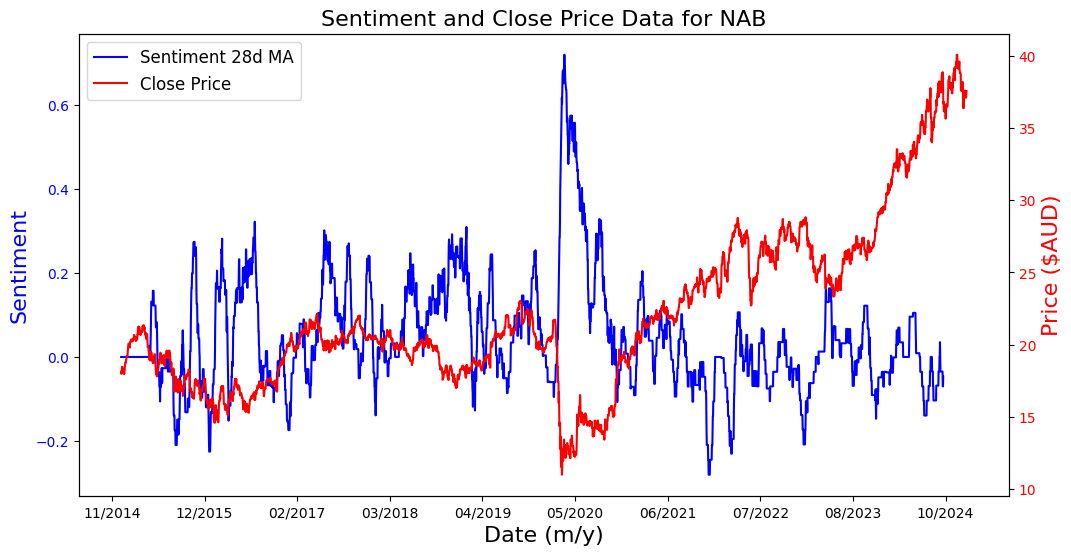

In [30]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_after_specific_date.index,
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['Close'],
         color='red', label='Close Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Close Price Data for ' + stock_code.upper(), fontsize=16)

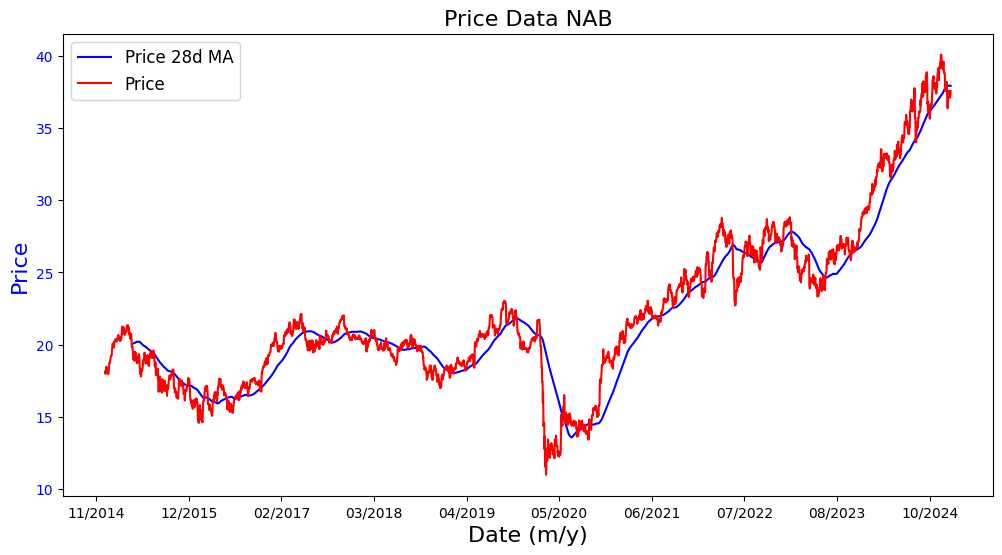

In [31]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(stock_data.index,
         stock_data['close_120_ma'], color='blue', label='Price 28d MA')

ax1.plot(stock_data.index,
         stock_data['Close'], color='red', label='Price')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Price Data ' + stock_code.upper(), fontsize=16)

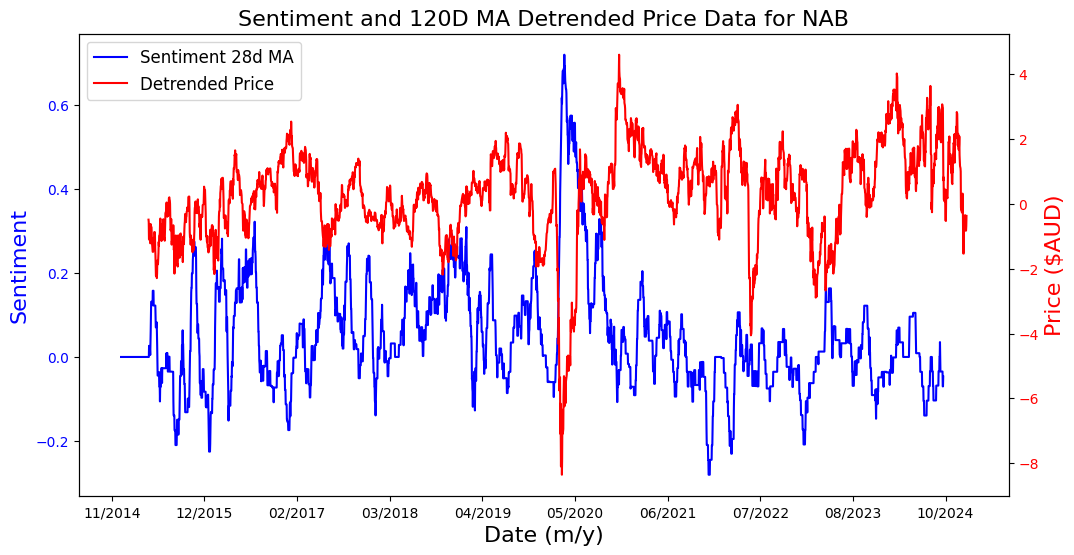

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index,
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['close_diff'],
         color='red', label='Detrended Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and 120D MA Detrended Price Data for ' + stock_code.upper(), fontsize=16)

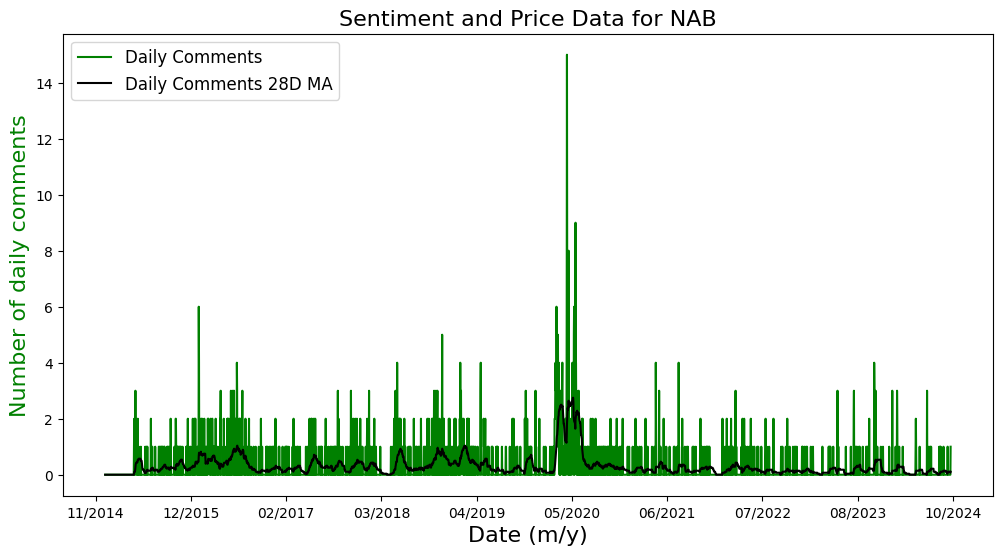

In [33]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index,
         df_after_specific_date['entry_count'], color='green', label='Daily Comments')

ax1.plot(df_after_specific_date.index,
         df_after_specific_date['entry_count_ma'], color='k', label='Daily Comments 28D MA')

ax1.set_ylabel('Number of daily comments', color='green', fontsize=16)
ax1.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Add legend
ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Price Data for ' + stock_code.upper(), fontsize=16)